#Part 0: Import and Preprocessing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
torch.__version__

'1.10.0+cu111'

In [3]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html
!pip install transformers
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     |████████████████████████████████| 3.1 MB 5.1 MB/s 
     |████████████████████████████████| 61 kB 500 kB/s 
     |████████████████████████████████| 895 kB 50.7 MB/s 
     |████████████████████████████████| 3.3 MB 44.2 MB/s 
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-1qt61bus
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-1qt61bus
     |████████████████████████████████| 49 kB 2.4 MB/s 
     |████████████████████████████████| 74 kB 3.1 MB/s 
     |████████████████████████████████| 145 kB 50.7 MB/s 
     |████████████████████████████████| 130 kB 51.5 MB/s 
     |████████████████████████████████| 843 kB 48.7 MB/s 
     |████████████████████████████████| 749 kB 46.8 MB/s 
     |████████████████████████████████| 112 kB 49.3 MB/s 
  Created wheel for detectron2: filename=detectron2-0.6-cp37-cp37m-linux_x86_64.whl size=5717341 sha256=c7121daba2f7a22fac583411f39d9d60523d203f0c20937f7ca8f1cb77e94d3

In [4]:
import tensorflow as tf

import  torchvision
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
import cv2
from PIL import Image
from transformers import BertTokenizer, VisualBertForPreTraining, VisualBertModel
from google.colab.patches import cv2_imshow
from tqdm import tqdm
from copy import deepcopy
from time import strftime
from time import gmtime
import h5py

In [5]:
# import some common pytorch utilities
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch
import torch.optim as optim
import torchvision.utils as vutils

from pycocotools.coco import COCO
from collections import Counter
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
nltk.download('punkt')

from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.structures.image_list import ImageList
from detectron2.structures import BoxMode
from detectron2.data import transforms as T
from detectron2.modeling.box_regression import Box2BoxTransform
from detectron2.engine import DefaultTrainer
# from detectron2.modeling.roi_heads.fast_rcnn import FastRCNNOutputs
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures.boxes import Boxes
from detectron2.layers import nms
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import build_detection_test_loader
from detectron2.data import build_detection_train_loader
from detectron2.data.samplers.distributed_sampler import InferenceSampler
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


###Define Paths for Output

In [6]:
BASE_DIR = '/content/drive/My Drive/CMPT413_FINAL_PROJECT'
os.makedirs(BASE_DIR, exist_ok=True)
DATA_DIR = '{}/data'.format(BASE_DIR)
os.makedirs(DATA_DIR, exist_ok=True)
IMAGEFEATURE_DIR = '{}/image_feature'.format(DATA_DIR)
os.makedirs(IMAGEFEATURE_DIR, exist_ok=True)
BATCHED_IMAGE_DIR = '{}/BATCHED_IMAGE'.format(DATA_DIR)
os.makedirs(BATCHED_IMAGE_DIR, exist_ok=True)

# Used to save processed features extract from 

###Download Data using Tensorflow API

In [7]:

annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510582272/13510573713 [==============================] - 252s 0us/step


###Read Annotations into Memory

In [8]:
with open('annotations/captions_train2014.json') as f:
    a = json.load(f)


###Preview Data

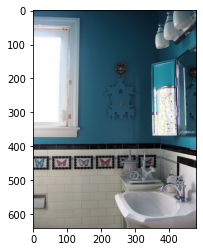

A very clean and well decorated empty bathroom


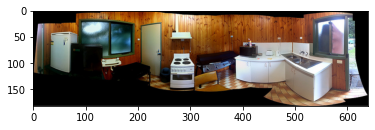

A panoramic view of a kitchen and all of its appliances.


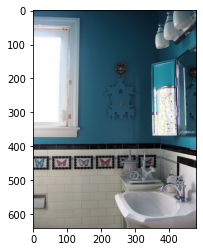

A blue and white bathroom with butterfly themed wall tiles.


In [9]:
# demo for get and convert single image to bgr image


for idx in range(3):
  ann_info = a['annotations'][idx]
  image_id = ann_info['image_id']
  img1 = plt.imread(f'train2014/COCO_train2014_{image_id:012d}.jpg')

  # Detectron expects BGR images
  img_bgr1 = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)

  plt.imshow(img1)
  plt.show()
  print(ann_info['caption'])

###Generate Annotation Dictionary

In [10]:
listOfAnn = a['annotations']

In [11]:
# Use smaller dataset for now
# Comment out this line before real trainning
# random.shuffle(listOfAnn)
# listOfAnn = listOfAnn[:10000]

In [12]:
image_path_to_caption = {}
for val in listOfAnn:
  caption = val['caption']
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path] = caption
  

In [13]:
# Get the list of image path
print(list(image_path_to_caption.items())[0])
len(list(image_path_to_caption.items()))

('/content/train2014/COCO_train2014_000000318556.jpg', 'A clock that blends in with the wall hangs in a bathroom. ')


82783

In [14]:
def load_image(image_path):
    img_bgr = cv2.imread(image_path)
    # img = cv2.resize(img, (299, 299)) 

    # Detectron expects BGR images
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return img ,img_bgr, image_path

#Part 1: Mask RCNN Training

###Prepare Data for Detectron2

In [ ]:

with open("annotations/instances_train2014.json") as f:
    ann_json = json.load(f)
thing_classes = [i['name'] for i in ann_json['categories']]
classes_map = {i['id']:i['name'] for i in ann_json['categories']}
classes_map_rev = {v['name']:i for i, v in enumerate(ann_json['categories'])}

In [ ]:
def get_detection_data():
    data_dirs = 'train2014'
    dataset = []

    json_file = "annotations/instances_train2014.json"

    with open(json_file) as f:
        ann_json = json.load(f)

    ann_map = {}
    # check json file exist
    if "annotations" in ann_json:
        imgs_anns = ann_json['annotations']
        for idx, v in enumerate(imgs_anns):
            image_id = v['image_id']
            class_id = classes_map_rev[classes_map[v['category_id']]]
            ann = {
                'id': v['id'],
                'segmentation': v['segmentation'],
                'bbox_mode': BoxMode.XYWH_ABS,
                'bbox': v['bbox'],
                'category_id' : class_id,
                'iscrowd': v['iscrowd']
            }

            if image_id not in ann_map:
                ann_map[image_id] = []

            ann_map[image_id].append(ann)
            
    else:
        imgs_anns = []


    dataset_dicts = []
    imgs_info = ann_json['images']
    for img_info in tqdm(imgs_info):
        record = {}
        image_id = img_info['id']
        record["file_name"] = os.path.join(data_dirs, img_info['file_name'])
        record["image_id"] = image_id
        record["height"] = img_info['height']
        record["width"] = img_info['width']
        if image_id in ann_map:
            record["annotations"] = ann_map[image_id]
        else:
            record["annotations"] = []

        dataset_dicts.append(record)

    return dataset_dicts

coco_mask_train = get_detection_data()

100%|██████████| 82783/82783 [00:00<00:00, 227232.73it/s]


In [ ]:
DatasetCatalog.clear()
MetadataCatalog.clear()
DatasetCatalog.register("coco_mask_train", get_detection_data)
MetadataCatalog.get("coco_mask_train").set(thing_classes=thing_classes)
data_metadata = MetadataCatalog.get("coco_mask_train")

###Preview Data

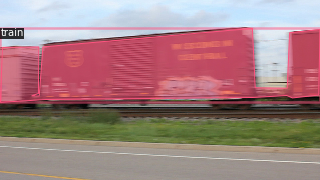

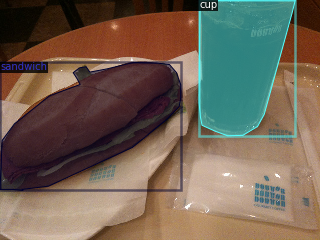

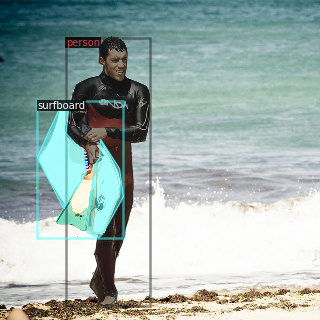

In [ ]:
for d in random.sample(coco_mask_train, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=data_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

###Define Hyperparameter and Training

In [ ]:
cfg = get_cfg()
cfg.OUTPUT_DIR = "{}/instance_output/".format(BASE_DIR)
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("coco_mask_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.WEIGHT_DECAY = 0.0001
cfg.SOLVER.MOMENTUM = 0.9 
cfg.SOLVER.MAX_ITER = 100  
cfg.SOLVER.STEPS = []       
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 91

In [ ]:
# custom trainer
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_lr_scheduler(cls, cfg, optimizer):
        """
        It now calls :func:`detectron2.solver.build_lr_scheduler`.
        Overwrite it if you'd like a different scheduler.
        """
        return torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.01, steps_per_epoch=len(coco_mask_train), epochs=cfg.SOLVER.MAX_ITER)

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[12/04 10:47:16 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

100%|██████████| 82783/82783 [00:00<00:00, 208829.01it/s]


[12/04 10:47:38 d2.data.build]: Removed 702 images with no usable annotations. 82081 images left.
[12/04 10:47:45 d2.data.build]: Distribution of instances among all 92 categories:
|   category   | #instances   |   category    | #instances   |   category    | #instances   |
|:------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
|  background  | 0            |    person     | 181682       |    bicycle    | 4912         |
|     car      | 30553        |  motorcycle   | 5972         |   airplane    | 3828         |
|     bus      | 4321         |     train     | 3158         |     truck     | 7047         |
|     boat     | 7457         | traffic light | 9125         | fire hydrant  | 1316         |
| street sign  | 0            |   stop sign   | 1372         | parking meter | 833          |
|    bench     | 6741         |     bird      | 7117         |      cat      | 3299         |
|     dog      | 3767         |     horse     | 4652         |     

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (92, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (92,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (364, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (364,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (91, 256, 1

[12/04 10:47:55 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/04 10:49:19 d2.utils.events]:  eta: 0:05:36  iter: 19  total_loss: 4.249  loss_cls: 2.685  loss_box_reg: 0.7672  loss_mask: 0.6862  loss_rpn_cls: 0.01233  loss_rpn_loc: 0.04791  time: 4.1720  data_time: 0.0939  lr: 0.0004  max_mem: 8832M
[12/04 10:50:40 d2.utils.events]:  eta: 0:04:09  iter: 39  total_loss: 2.89  loss_cls: 1.389  loss_box_reg: 0.7515  loss_mask: 0.6451  loss_rpn_cls: 0.02478  loss_rpn_loc: 0.05173  time: 4.1176  data_time: 0.0410  lr: 0.0004  max_mem: 8832M
[12/04 10:52:01 d2.utils.events]:  eta: 0:02:44  iter: 59  total_loss: 2.397  loss_cls: 1.039  loss_box_reg: 0.6684  loss_mask: 0.6044  loss_rpn_cls: 0.01805  loss_rpn_loc: 0.06367  time: 4.0953  data_time: 0.0480  lr: 0.0004  max_mem: 8832M
[12/04 10:53:27 d2.utils.events]:  eta: 0:01:23  iter: 79  total_loss: 2.455  loss_cls: 1.081  loss_box_reg: 0.7184  loss_mask: 0.5358  loss_rpn_cls: 0.01436  loss_rpn_loc: 0.06282  time: 4.1449  data_time: 0.0470  lr: 0.0004  max_mem: 8832M
[12/04 10:54:54 d2.utils.events]:

In [ ]:
cfg_path = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"

def load_config_and_model_weights(cfg_path):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(cfg_path))

    # ROI HEADS SCORE THRESHOLD
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

    # Comment the next line if you're using 'cuda'
    # cfg['MODEL']['DEVICE']='cpu'

    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(cfg_path)

    return cfg

cfg = load_config_and_model_weights(cfg_path)

In [ ]:
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

###Preview Model Output

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


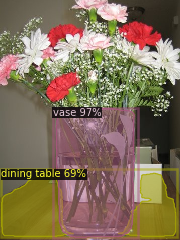

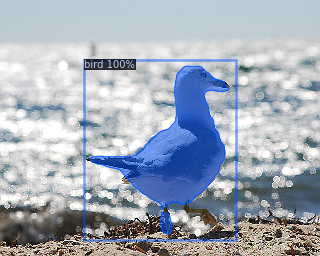

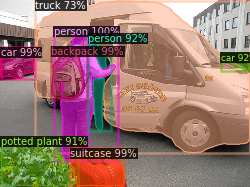

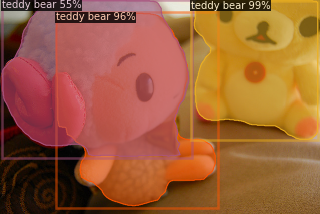

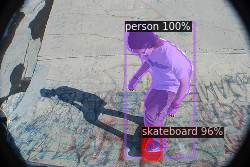

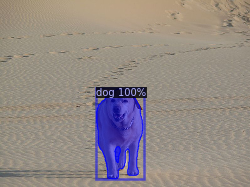

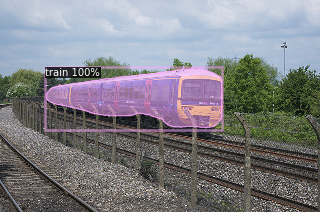

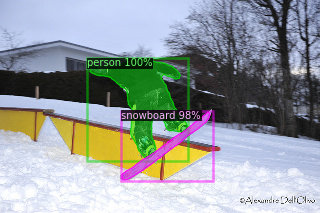

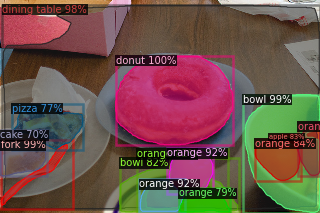

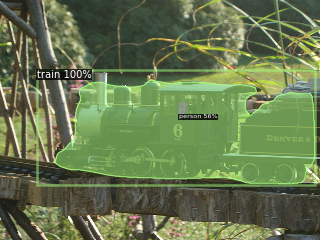

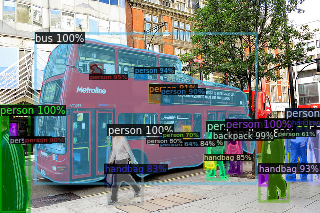

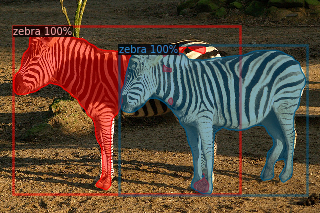

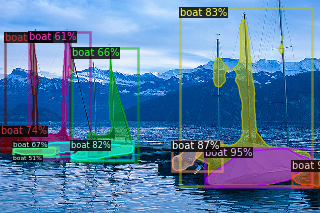

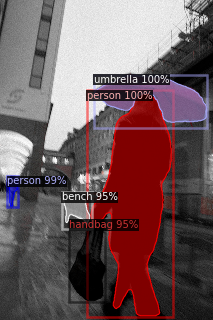

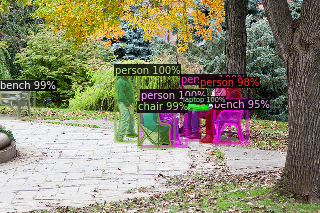

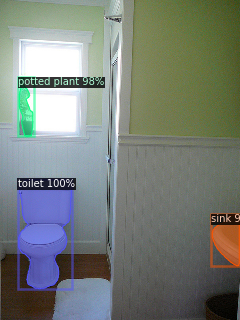

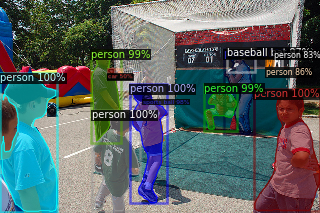

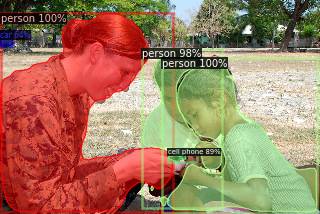

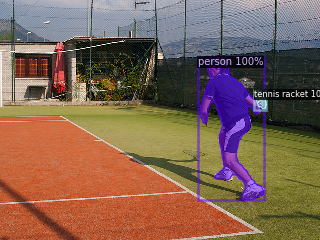

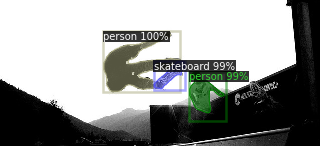

In [ ]:
for d in random.sample(coco_mask_train, 20):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=data_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

#Part 2: Generate and Save Mask RCNN Feature Embedding

This part is adapted from:https://colab.research.google.com/drive/1bLGxKdldwqnMVA5x4neY7-l_8fKGWQYI?usp=sharing#scrollTo=zyAR_t3Uf0sX and https://colab.research.google.com/drive/1NNSRd5aPRFYLjI6oAjyAGlntIRuWW5mB#scrollTo=zXR0217aRPFR

###Define helper functions

Class FastRCNNOutputs was removed from the newer version of Detectron2.
Please refer to this guide to fix the issue.
https://issueexplorer.com/issue/facebookresearch/unbiased-teacher/44
They fixed a similar issue for different projects.
If you are running this notebook on colab, please add the class (code provided in the link above) to the end of [usr/local/lib/python3.7/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py](usr/local/lib/python3.7/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py)

In [ ]:
from detectron2.modeling.roi_heads.fast_rcnn import FastRCNNOutputs

cfg_path = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"

def load_config_and_model_weights(cfg_path):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(cfg_path))

    # ROI HEADS SCORE THRESHOLD
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

    # Comment the next line if you're using 'cuda'
    # cfg['MODEL']['DEVICE']='cpu'

    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(cfg_path)

    return cfg

cfg = load_config_and_model_weights(cfg_path)

In [ ]:
# This block of code is from https://colab.research.google.com/drive/1bLGxKdldwqnMVA5x4neY7-l_8fKGWQYI?usp=sharing#scrollTo=j4Sh6otik73l

def get_model(cfg):
    # build model
    model = build_model(cfg)

    # load weights
    checkpointer = DetectionCheckpointer(model)
    checkpointer.load(cfg.MODEL.WEIGHTS)

    # eval mode
    model.eval()
    return model

model = get_model(cfg)

model_final_a3ec72.pkl: 254MB [00:04, 53.2MB/s]                           


In [ ]:
# This block of code is from https://colab.research.google.com/drive/1bLGxKdldwqnMVA5x4neY7-l_8fKGWQYI?usp=sharing#scrollTo=j4Sh6otik73l

def prepare_image_inputs(cfg, model, img_list):
  with torch.no_grad():
    # Resizing the image according to the configuration
    transform_gen = T.ResizeShortestEdge(
                [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
            )
    img_list = [transform_gen.get_transform(img).apply_image(img) for img in img_list]

    # Convert to C,H,W format
    convert_to_tensor = lambda x: torch.Tensor(x.astype("float32").transpose(2, 0, 1))

    batched_inputs = [{"image":convert_to_tensor(img), "height": img.shape[0], "width": img.shape[1]} for img in img_list]

    # Normalizing the image
    num_channels = len(cfg.MODEL.PIXEL_MEAN)
    pixel_mean = torch.Tensor(cfg.MODEL.PIXEL_MEAN).view(num_channels, 1, 1)
    pixel_std = torch.Tensor(cfg.MODEL.PIXEL_STD).view(num_channels, 1, 1)
    normalizer = lambda x: (x - pixel_mean) / pixel_std
    images = [normalizer(x["image"]) for x in batched_inputs]

    # Convert to ImageList
    images =  ImageList.from_tensors(images,model.backbone.size_divisibility)
    
    return images, batched_inputs

In [ ]:
def get_features(model, images):
  with torch.no_grad():
    features = model.backbone(images.tensor.cuda())
    torch.cuda.empty_cache()
    return features

In [ ]:
imagePath = list(image_path_to_caption.keys())[0]
imageList = []
_, img_bgr, _, = load_image(imagePath)
imageList.append(img_bgr)
images, batched_inputs = prepare_image_inputs(cfg, model, imageList)
features = get_features(model, images)


In [ ]:
print(imagePath)

/content/train2014/COCO_train2014_000000068293.jpg


###Preview FPN Feature Extraction

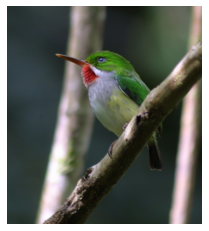

In [ ]:
# Use to check if features are generated correctly
img, img_bgr, _, = load_image(imagePath)
plt.imshow(img)
plt.axis('off')
plt.show()


p2


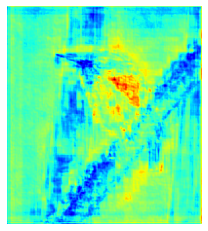

p3


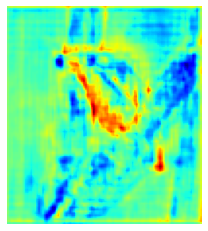

p4


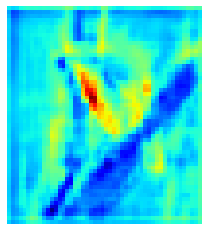

p5


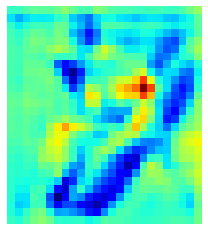

p6


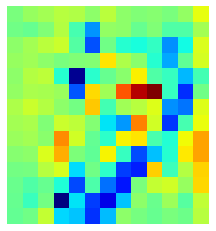

In [ ]:
# Use to check if features are generated correctly
for key in features.keys():
  print(key)
  plt.imshow(features[key][0,0,:,:].squeeze().detach().cpu().numpy(), cmap='jet')
  plt.axis('off')
  plt.show()

###Filter Bounding Box Proposals and Generate Feature Extraction for each Box

In [ ]:
def get_proposals(model, images, features):
  with torch.no_grad():
    proposals, _ = model.proposal_generator(images, features)
    return proposals

In [ ]:
def get_box_features(model, features, proposals, batch_size):
    features_list = [features[f] for f in ['p2', 'p3', 'p4', 'p5']]
    box_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
    box_features = model.roi_heads.box_head.flatten(box_features)
    box_features = model.roi_heads.box_head.fc1(box_features)
    box_features = model.roi_heads.box_head.fc_relu1(box_features)
    box_features = model.roi_heads.box_head.fc2(box_features)

    box_features = box_features.reshape(batch_size, -1, 1024) # depends on your config and batch size
    # pad = torch.nn.utils.rnn.pad_sequence([box_features, torch.zeros(1000, 1024)], batch_first=True)
    # box_features = pad[:-1]
    return box_features, features_list



In [ ]:
def get_prediction_logits(model, features_list, proposals):
    cls_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
    cls_features = model.roi_heads.box_head(cls_features)
    pred_class_logits, pred_proposal_deltas = model.roi_heads.box_predictor(cls_features)
    pred_class_logits = pred_class_logits.reshape(-1, 81)
    pred_proposal_deltas = pred_proposal_deltas.reshape(-1, 320)
    return pred_class_logits, pred_proposal_deltas



In [ ]:
def get_box_scores(cfg, pred_class_logits, pred_proposal_deltas, proposals):
    box2box_transform = Box2BoxTransform(weights=cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_WEIGHTS)
    smooth_l1_beta = cfg.MODEL.ROI_BOX_HEAD.SMOOTH_L1_BETA
    outputs = FastRCNNOutputs(
        box2box_transform,
        pred_class_logits,
        pred_proposal_deltas,
        proposals,
        smooth_l1_beta,
    )

    boxes = outputs.predict_boxes()
    scores = outputs.predict_probs()
    image_shapes = outputs.image_shapes

    return boxes, scores, image_shapes

In [ ]:
def get_output_boxes(boxes, batched_inputs, image_size):
    proposal_boxes = boxes.reshape(-1, 4).clone()
    scale_x, scale_y = (batched_inputs["width"] / image_size[1], batched_inputs["height"] / image_size[0])
    output_boxes = Boxes(proposal_boxes)

    output_boxes.scale(scale_x, scale_y)
    output_boxes.clip(image_size)

    return output_boxes

In [ ]:
def select_boxes(cfg, output_boxes, scores):
    test_score_thresh = cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST
    test_nms_thresh = cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST
    cls_prob = scores.detach()
    cls_boxes = output_boxes.tensor.detach().reshape(-1,80,4)
    max_conf = torch.zeros((cls_boxes.shape[0]))
    for cls_ind in range(0, cls_prob.shape[1]-1):
        cls_scores = cls_prob[:, cls_ind+1].cpu()
        det_boxes = cls_boxes[:,cls_ind,:].cpu()
        keep = np.array(nms(det_boxes, cls_scores, test_nms_thresh))
        max_conf[keep] = torch.where(cls_scores[keep] > max_conf[keep], cls_scores[keep], max_conf[keep])
    keep_boxes = torch.where(max_conf >= test_score_thresh)[0]
    return keep_boxes, max_conf

In [ ]:
def filter_boxes(keep_boxes, max_conf, min_boxes, max_boxes):
    if len(keep_boxes) < min_boxes:
        keep_boxes = np.argsort(max_conf).numpy()[::-1][:min_boxes]
    elif len(keep_boxes) > max_boxes:
        keep_boxes = np.argsort(max_conf).numpy()[::-1][:max_boxes]
    return keep_boxes

In [ ]:
def get_visual_embeds(box_features, keep_boxes):
    return box_features[keep_boxes.copy()]

**Warning: running the visual embedding extracting process on COCO training set will take around 5 hours on google coloab**

In [ ]:
def save_visual_embeds(cfg, model, data):
    with h5py.File('visual_embeds.h5', 'w') as vh5:
        for path, caption in tqdm(data.items()):
            imageList = []
            _, img_bgr, _, = load_image(path)
            imageList.append(img_bgr)
            images, batched_inputs = prepare_image_inputs(cfg, model, imageList)
            features = get_features(model, images)
            proposals = get_proposals(model, images, features)
            box_features, features_list = get_box_features(model, features, proposals, 1)
            pred_class_logits, pred_proposal_deltas = get_prediction_logits(model, features_list, proposals)
            boxes, scores, image_shapes = get_box_scores(cfg, pred_class_logits, pred_proposal_deltas, proposals)
            output_boxes = [get_output_boxes(boxes[i], batched_inputs[i], proposals[i].image_size) for i in range(len(proposals))]
            temp = [select_boxes(cfg, output_boxes[i], scores[i]) for i in range(len(scores))]
            keep_boxes, max_conf = [],[]
            for keep_box, mx_conf in temp:
                keep_boxes.append(keep_box)
                max_conf.append(mx_conf)
            MIN_BOXES=10
            MAX_BOXES=100
            keep_boxes = [filter_boxes(keep_box, mx_conf, MIN_BOXES, MAX_BOXES) for keep_box, mx_conf in zip(keep_boxes, max_conf)]
            visual_embeds = [get_visual_embeds(box_feature, keep_box) for box_feature, keep_box in zip(box_features, keep_boxes)]
            vh5[path] = visual_embeds[0].cpu().detach().numpy()

save_visual_embeds(cfg, model, image_path_to_caption)

100%|██████████| 82783/82783 [4:50:09<00:00,  4.76it/s]


Copy saved visual embedings to google drive.

**Warning: Total size of visual embedings of COCO training set is over 30G. Please make sure your drive have enough space before running this.**

In [ ]:
!cp /content/visual_embeds.h5 /content/drive/MyDrive/CMPT413_FINAL_PROJECT

#Part 3: Basic Transformer Model Definition and Training

Copy visual embeddings from google drive

In [15]:
!cp /content/drive/MyDrive/CMPT413_FINAL_PROJECT/visual_embeds.h5 /content 

###Generating Vocabulary for COCO Caption Annotations

In [16]:
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)
        
def build_vocab(json, threshold):
    """Build a simple vocabulary wrapper."""
    coco = COCO(json)
    counter = Counter()
    ids = coco.anns.keys()
    for i, id in enumerate(ids):
        caption = str(coco.anns[id]['caption'])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)

        if i % 1000 == 0:
            print("[%d/%d] Tokenized the captions." %(i, len(ids)))

    # If the word frequency is less than 'threshold', then the word is discarded.
    words = [word for word, cnt in counter.items() if cnt >= threshold]

    # Creates a vocab wrapper and add some special tokens.
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    # Adds the words to the vocabulary.
    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab

vocab = build_vocab(json='annotations/captions_train2014.json', threshold=5)

loading annotations into memory...
Done (t=0.91s)
creating index...
index created!
[0/414113] Tokenized the captions.
[1000/414113] Tokenized the captions.
[2000/414113] Tokenized the captions.
[3000/414113] Tokenized the captions.
[4000/414113] Tokenized the captions.
[5000/414113] Tokenized the captions.
[6000/414113] Tokenized the captions.
[7000/414113] Tokenized the captions.
[8000/414113] Tokenized the captions.
[9000/414113] Tokenized the captions.
[10000/414113] Tokenized the captions.
[11000/414113] Tokenized the captions.
[12000/414113] Tokenized the captions.
[13000/414113] Tokenized the captions.
[14000/414113] Tokenized the captions.
[15000/414113] Tokenized the captions.
[16000/414113] Tokenized the captions.
[17000/414113] Tokenized the captions.
[18000/414113] Tokenized the captions.
[19000/414113] Tokenized the captions.
[20000/414113] Tokenized the captions.
[21000/414113] Tokenized the captions.
[22000/414113] Tokenized the captions.
[23000/414113] Tokenized the capt

###Define Our Custom COCO Dataset for Loading Visual Embeddings

In [17]:
def collate_fn(batch):
    src_batch, tgt_batch, path_batch = [], [], []
    for src_sample, tgt_sample, path in batch:
        src_batch.append(src_sample)
        tgt_batch.append(tgt_sample)
        path_batch.append(path)

    src_batch = torch.nn.utils.rnn.pad_sequence(src_batch)
    tgt_batch = torch.nn.utils.rnn.pad_sequence(tgt_batch, padding_value=0).type(torch.long)
    return src_batch, tgt_batch, path_batch

class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

class CocoCaptionDataset(Dataset):
    def __init__(self, path_caption_dict, vocab):
        self.data = list(path_caption_dict.items())
        self.vocab = vocab
        self.h5 = h5py.File('visual_embeds.h5', 'r')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.item()
        (path, caption) = self.data[idx]

        embed = torch.tensor(np.array(self.h5[path]))
        # set_list = list(h5f[set_dir])
        # embed = self.visual_embed(path)

         # Convert caption (string) to word ids.
        tokens = nltk.tokenize.word_tokenize(str(caption[0]).lower())
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)

        return embed, target, path

###Split and Limit the Size of Traning and Validation Data

In [18]:
listOfAnn = a['annotations']
path_caption_dict = collections.defaultdict(list)
for val in listOfAnn:
  caption = val['caption']
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  path_caption_dict[image_path].append(caption)
print(list(path_caption_dict.items())[10])
len(list(path_caption_dict.items()))

('/content/train2014/COCO_train2014_000000513461.jpg', ['A surfer, a woman, and a child walk on the beach.', 'A person holding a surf board on a beach. ', 'A family standing next to the ocean on a sandy beach with a surf board.', 'A man getting ready to surf as lookers walk by', 'A family carrying a surfboard to the ocean.'])


82783

In [19]:
def sample_from_dict(d, train_size, val_size):
    sample = train_size + val_size
    keys = random.sample(list(d), sample)
    values = [d[k] for k in keys]
    tkeys, tvals = keys[:train_size], values[:train_size]
    vkeys, vvals = keys[train_size:], values[train_size:]
    return dict(zip(tkeys, tvals)), dict(zip(vkeys, vvals))

In [20]:
train_path_caption_dict, val_path_caption_dict = sample_from_dict(path_caption_dict, 10000, 1000)
print(list(train_path_caption_dict.items())[0])
print(len(list(train_path_caption_dict.items())))
print(list(val_path_caption_dict.items())[0])
print(len(list(val_path_caption_dict.items())))

('/content/train2014/COCO_train2014_000000206975.jpg', ['A large train yard with no running trains', 'A train is shown sitting on the tracks at a station.', 'A train yard in a city with a train in the distance', 'A area with lots of railroad tracks with no trains on them.', 'Industrial area of train tracks, where it lone lily extends for a long distance with city behind scene.'])
10000
('/content/train2014/COCO_train2014_000000014335.jpg', ['A computer desk has a laptop and a desktop.', 'A desk that has three type of computers on it.', 'three computer on a desk with a mouse and keyboard', 'A couple of computer monitors on top of a wooden desk.', 'Two computer monitors are next to a laptop on the desk.'])
1000


In [21]:
path_caption_dict['/content/train2014/COCO_train2014_000000248018.jpg']

['An entree of vegetated and soups in a bowl and plate',
 'A white bowl of dip sits next to a bag of potato chips.',
 'A cup of soup, a side of salad and a bag of potato chips.',
 'A close-up of a salad, potato chips and a bowl of soup.',
 'Thee is soup, some salad and a bag of potato chips. ']

In [22]:
dataset_train = CocoCaptionDataset(train_path_caption_dict, vocab)
dataset_val = CocoCaptionDataset(val_path_caption_dict, vocab)
loader = DataLoader(dataset_val, batch_size=16, num_workers=0, shuffle=True, collate_fn=collate_fn)

In [23]:
for (embed, caption, path) in loader:
    print(caption)
    print(embed)
    print(path)
    print(caption.shape)
    print(embed.shape)
    break

tensor([[   1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            1,    1,    1,    1],
        [  33,    4,   51,    4,    4,    4,   99, 4938,    4,   48,    4,    4,
           33,    4,    4,    4],
        [ 858,    3,  455,   99,  265,  331,   40,   14,   60,  240, 1755,   60,
          550,  278,   99,   99],
        [  29,  758,   22,  286,  768,   14,    4,  604, 2053,    3,   14,  372,
           14,  225,   78,  361],
        [ 131, 1322,  212,   55,  133, 2997,  135,  832,  116,  132,   61,  325,
            4,   40,  585,   48],
        [   6,  193,  149,  112,  327, 5418,  436,  614,  892,   40,    7,   40,
           92,    4, 1272,  104],
        [   7,   78,  365,  279,  933,  509,  286,    7,  249,  258,   21,  258,
          409,   56, 2742,   22],
        [  10,   33,  162,  399,   40,   78,   33, 1121,    4,   14, 2337,   14,
          526,   80,  664,    4],
        [  14,  137,    4,    4,    4,    4,  573, 1755,  120,    4,   53,    4,

###Define Transformer Seq2Seq Model

This part is adapted from pytorch official transformer tutorial.
https://pytorch.org/tutorials/beginner/translation_transformer.html

In [24]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        tgt = self.tgt_tok_emb(trg)
        tgt_emb = self.positional_encoding(tgt)
        src_emb = self.positional_encoding(src)
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(src), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [25]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]
    batch_size = src.shape[1]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    # src_padding_mask = (src == 0).transpose(0, 1)
    src_padding_mask = torch.zeros(batch_size, src_seq_len).type(torch.bool).cuda()
    tgt_padding_mask = (tgt == 0).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

###Define Hyperparameter and Training

In [ ]:
numberOfEpoch = 50
learning_rate = 0.0001

saveEpoch = 10

TGT_VOCAB_SIZE = len(vocab)
EMB_SIZE = 1024
NHEAD = 8
FFN_HID_DIM = 1028
BATCH_SIZE = 64
NUM_ENCODER_LAYERS = 6
NUM_DECODER_LAYERS = 6

In [ ]:

tfdecoder = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, TGT_VOCAB_SIZE, FFN_HID_DIM)

tfdecoder.cuda()
criterion = nn.CrossEntropyLoss(ignore_index=0)

train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=2, shuffle=True, collate_fn=collate_fn)

# optimizer = torch.optim.SGD(tfdecoder.parameters(), lr=learning_rate, momentum=0.9)
optimizer = torch.optim.Adam(tfdecoder.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0001, steps_per_epoch=len(train_loader), epochs=numberOfEpoch)

total_step = len(train_loader)
prev_time = time.time()

for epoch in range(numberOfEpoch):
    epoch_loss = 0
    for i, (vembed, captions, path) in enumerate(train_loader):

        vembed = vembed.cuda()
        captions = captions.cuda()
        tgt_input  = captions[:-1, :]
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(vembed, tgt_input)

        outputs = tfdecoder(vembed, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        tgt_out  = captions[1:, :]
        loss = criterion(outputs.reshape(-1, outputs.shape[-1]), tgt_out.reshape(-1))
        tfdecoder.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()

    epoch_loss /= total_step
    # Print log info
    pred = outputs[:, 0].reshape(-1, outputs.shape[-1]).argmax(-1)
    predtokens = [vocab.idx2word[idx] for idx in pred.cpu().numpy()]
    truetokens = [vocab.idx2word[idx] for idx in captions[:, 0].reshape(-1).cpu().numpy()]
    print('pred: ' + " ".join(predtokens))
    print('true: ' + " ".join(truetokens))
    curr_time = time.time()
    time_cost = curr_time - prev_time
    prev_time = curr_time
    print('Epoch [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}, time cost:{}s'
    .format(epoch, numberOfEpoch, epoch_loss, np.exp(epoch_loss), round(time_cost, 2)))
    
    if epoch % saveEpoch == 0:    
        torch.save(tfdecoder.state_dict(), os.path.join(
            BASE_DIR, 'transformer.ckpt'))
        
  # Save the model checkpoints
torch.save(tfdecoder.state_dict(), os.path.join(
        BASE_DIR, 'transformer.ckpt'))

pred: a a a a a a <end> <end> <end> . <end> <end> <end> . . <end> <end> <end> <end> <end> <end> <end> <end> .
true: <start> a donut is sitting on a napkin with a few bites out of it . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Epoch [0/50], Loss: 6.8331, Perplexity: 928.0459, time cost:71.54s
pred: a of a a of of of a of a a . . a . <end> . . <end>
true: <start> a plate with a hot dog and others , with a can of soda . <end> <pad> <pad> <pad>
Epoch [1/50], Loss: 5.6541, Perplexity: 285.4470, time cost:73.37s
pred: a man on of on a of a with a <end> <end> <end> <end> <end>
true: <start> a can is sitting on top of a dog . <end> <pad> <pad> <pad> <pad>
Epoch [2/50], Loss: 4.8727, Perplexity: 130.6693, time cost:71.47s
pred: a a a of of and and and a a table . . . . . a . . a table . . . a . <end>
true: <start> on one plate there is glazed donut and on the other plate there is mug of hot chocolate with a leaf shape swirled in it . <end>
Epoch [3/50], Loss: 4.3144, Perplexity: 74.

#Part 4: Basic Transformer Model Evaluation

###Define Greedy Decode Process

In [26]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        # _, next_word = torch.topk(prob, 2, dim=1)
        # next_word = next_word[0, 1]
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        # print(next_word)
        ys = torch.cat([ys,
                        torch.ones(1, 1).fill_(next_word).type(torch.long).cuda()], dim=0)
        # print(ys)
        if next_word == 2:
            break
    return ys

###Load Saved Model and Preview Some Result

In [ ]:
modelload = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, TGT_VOCAB_SIZE, FFN_HID_DIM).cuda()
modelload.load_state_dict(torch.load('{}/transformer_50.ckpt'.format(BASE_DIR)))
modelload.eval()
val_loader = DataLoader(dataset_val, batch_size=1, num_workers=2, shuffle=True, collate_fn=collate_fn)

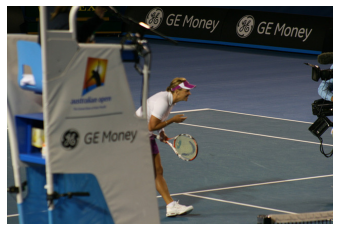

pred: person is holding tennis racquet , wearing uniform , and tennis ball tennis racquet .
true: a tennis player bent over holding a tennis racket .
a tennis player on the tennis court
a woman bending over with a tennis racket in her hand .
the woman is holding her tennis racket .
there is a tennis player that is playing tennis


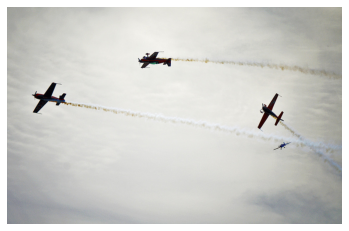

pred: jet flying through the air while riding skateboard .
true: four planes flying together with spoke streams
airplanes doing stunts an an air shown in a cloudy sky .
four fighter jets soar across the sky .
four old time airplanes doing some tricks and aerobatics
four airplanes with smoke flying in the sky .


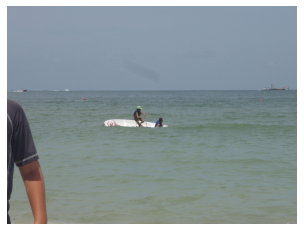

pred: woman on surfboard in the water .
true: two people are hanging onto a surfboard in the ocean .
a man with a surf board standing among the waves
two men trying to flip a surf board back over .
two people are near a surfboard in the ocean .
people that are on top of a surfboard in the water .


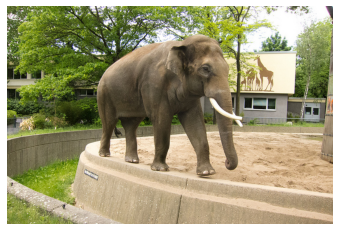

pred: an elephant standing on top of dirt road
true: large grey elephant walking around an enclosure at a zoo .
an elephant with white tusk talking on top of a cement structure .
an elephant walks on a low concrete wall .
a elephant walking the edge of its raised enclosure at a zoo .
an elephant with buildings and trees in the background


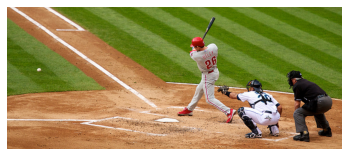

pred: baseball player holding bat during game .
true: a group of baseball players and an umpire playing baseball .
a baseball player is swinging a bat at a game
a catcher and an umpire standing behind a player swinging the bat .
a group of men in a field playing baseball .
baseball player in the batting box finishing a swing of the bat .


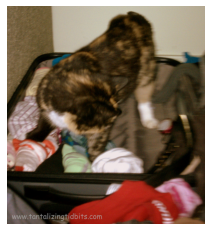

pred: cat sitting on top of laptop computer .
true: a cat standing in a open suitcase on some cloths .
a cat that is resting in a full bag of luggage .
a cat lays inside of a suitcase with clothes in it
a cat standing in a laundry hamper looking down .
an animal sitting in a suit case filled with clothing .


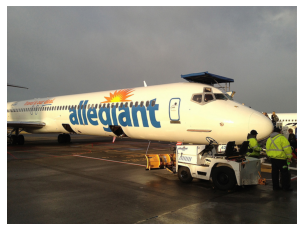

pred: truck parked on the ground near some people .
true: a large air plane on an air port runway
workers standing in front of the the fuselage of an airplane .
an airplane sitting on a tarmac at an airport .
a long air plane on a landing strip next to a small carrying car and workers .
a light yellow airplane is stopped at the airport .


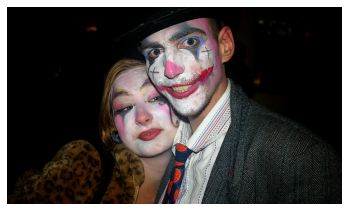

pred: close up of man wearing suit and tie .
true: a man and a woman are wearing clown makeup .
a young couple dressed up wearing clown makeup .
two adults with their faces painted as clowns .
man and woman wearing clown faces with makeup .
two people dressed like clowns smiling for a picture .


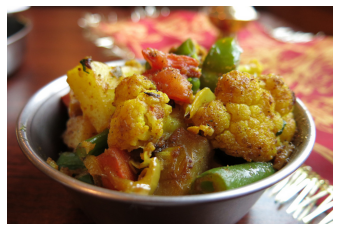

pred: bowl of vegetables are on table .
true: a bowl of food that includes vegetables and fried foods .
a close up of a bowl of food
an image of a white bowl holding a plate of food
a bowl of food with vegetables and some meats .
a dish if full of various vegetables .


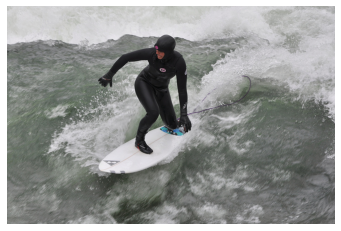

pred: young man riding wave on top of surfboard .
true: the person wearing a black wet suit is balancing on a surfboard .
surfer riding wave as it begins to break in river .
a person riding a wave on top of a surfboard .
this person is in a solid black wetsuit riding a wave
a person in a full body wetsuit standing on a surfboard and surfing on a wave .


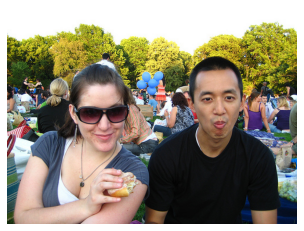

pred: man who is sitting down with cell phone .
true: a woman smiling and holding a sandwich next to a young man
this two people are enjoying food at their picnic
a very pretty girl with food by a funny face guy .
the man and the woman are posing for a picture .
a man and woman are enjoying a sub on the ground


In [ ]:
for i, (vembed, captions, path) in enumerate(val_loader):
    with torch.no_grad():
        vembed = vembed.cuda()
        num_tokens = vembed.shape[0]
        src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
        tgt_tokens = greedy_decode(
            modelload, vembed, src_mask, max_len=num_tokens + 5, start_symbol=1).flatten()
        img, img_bgr, _, = load_image(path[0])
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        predtokens = [vocab.idx2word[idx] for idx in tgt_tokens.cpu().numpy() if idx > 4]
        gts = path_caption_dict[path[0]]
        truetokens = [' '.join(nltk.tokenize.word_tokenize(str(s).lower())) for s in gts]
        print('pred: ' + " ".join(predtokens))
        print('true: ' + "\n".join(truetokens))
        if i == 10:
            break

###Caclulate BLEU Score

In [ ]:
references = [] 
hypotheses = []
for i, (vembed, captions, path) in enumerate(tqdm(val_loader)):
    with torch.no_grad():
        vembed = vembed.cuda()
        num_tokens = vembed.shape[0]
        src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
        tgt_tokens = greedy_decode(
            modelload, vembed, src_mask, max_len=num_tokens + 5, start_symbol=1).flatten()
        predtokens = [vocab.idx2word[idx] for idx in tgt_tokens.cpu().numpy() if idx > 4]
        gts = path_caption_dict[path[0]]
        # truetokens = [' '.join(nltk.tokenize.word_tokenize(str(s).lower())) for s in gts]
        truetokens = [nltk.tokenize.word_tokenize(str(s).lower()) for s in gts]
        references.append(truetokens)
        # hypotheses.append(' '.join(predtokens))
        hypotheses.append(predtokens)
        # if i == 100:
        #     break
bleu = corpus_bleu(references, hypotheses, smoothing_function=SmoothingFunction().method1)
bleu_1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)
bleu_2 = corpus_bleu(references, hypotheses, weights=(0, 1, 0, 0), smoothing_function=SmoothingFunction().method1)
bleu_3 = corpus_bleu(references, hypotheses, weights=(0, 0, 1, 0), smoothing_function=SmoothingFunction().method1)
bleu_4 = corpus_bleu(references, hypotheses, weights=(0, 0, 0, 1), smoothing_function=SmoothingFunction().method1)
print("BLEU: "+str(bleu))
print("BLEU-1: "+str(bleu_1))
print("BLEU-2: "+str(bleu_2))
print("BLEU-3: "+str(bleu_3))
print("BLEU-4: "+str(bleu_4))

100%|██████████| 1000/1000 [01:06<00:00, 15.11it/s]


BLEU: 0.1957632837311422
BLEU-1: 0.5787657668863954
BLEU-2: 0.24786441127946615
BLEU-3: 0.12590519532920966
BLEU-4: 0.08131380874255476


#Part 5: VisualBert Model Definition and Training

###Define VisualBert Transformer Model

In [27]:
# Seq2Seq Network
class VisualBertTransformer(nn.Module):
    def __init__(self,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 tgt_vocab_size: int,
                 dropout: float = 0.1):
        super(VisualBertTransformer, self).__init__()

        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.bert = VisualBertModel.from_pretrained('uclanlp/visualbert-nlvr2-coco-pre').cuda()
        decoder_layer = nn.TransformerDecoderLayer(d_model=emb_size, nhead=nhead)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                tgt_mask: Tensor,
                tgt_padding_mask: Tensor):
        
        #visualbert batch first
        src = src.transpose(1, 0)

        questions = [''] * src.shape[0]
        tokens = self.tokenizer(questions, padding='max_length', max_length=0)
        self.input_ids = torch.tensor(tokens["input_ids"]).cuda()
        self.attention_mask = torch.tensor(tokens["attention_mask"]).cuda()
        self.token_type_ids = torch.tensor(tokens["token_type_ids"]).cuda()
        
        visual_attention_mask = torch.ones(src.shape[:-1], dtype=torch.long).cuda()
        visual_token_type_ids = torch.ones(src.shape[:-1], dtype=torch.long).cuda()
        outputs = self.bert(input_ids=self.input_ids, attention_mask=self.attention_mask,
                        token_type_ids=self.token_type_ids, visual_embeds=src,
                        visual_attention_mask=visual_attention_mask,
                        visual_token_type_ids=visual_token_type_ids)
        memory = outputs.last_hidden_state.transpose(1, 0)

        tgt = self.tgt_tok_emb(trg)
        tgt_emb = self.positional_encoding(tgt)

        outs = self.decoder(tgt=tgt_emb, memory=memory, tgt_mask=tgt_mask,
                     tgt_key_padding_mask=tgt_padding_mask)

        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        src = src.transpose(1, 0)

        questions = [''] * src.shape[0]
        tokens = self.tokenizer(questions, padding='max_length', max_length=0)
        self.input_ids = torch.tensor(tokens["input_ids"]).cuda()
        self.attention_mask = torch.tensor(tokens["attention_mask"]).cuda()
        self.token_type_ids = torch.tensor(tokens["token_type_ids"]).cuda()
        
        visual_attention_mask = torch.ones(src.shape[:-1], dtype=torch.long).cuda()
        visual_token_type_ids = torch.ones(src.shape[:-1], dtype=torch.long).cuda()
        outputs = self.bert(input_ids=self.input_ids, attention_mask=self.attention_mask,
                        token_type_ids=self.token_type_ids, visual_embeds=src,
                        visual_attention_mask=visual_attention_mask,
                        visual_token_type_ids=visual_token_type_ids)
        return outputs.last_hidden_state.transpose(1, 0)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        tgt = self.tgt_tok_emb(tgt)
        tgt_emb = self.positional_encoding(tgt)

        return self.decoder(tgt=tgt_emb, memory=memory, tgt_mask=tgt_mask)

In [ ]:
def define_bert():
    TGT_VOCAB_SIZE = len(vocab)
    EMB_SIZE = 768
    NHEAD = 8
    NUM_DECODER_LAYERS = 6

    return VisualBertTransformer(num_decoder_layers=NUM_DECODER_LAYERS,
                                        emb_size=EMB_SIZE, nhead=NHEAD,
                                        tgt_vocab_size=TGT_VOCAB_SIZE).cuda()

bertdecoder = define_bert()

Some weights of the model checkpoint at uclanlp/visualbert-nlvr2-coco-pre were not used when initializing VisualBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing VisualBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing VisualBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


###Re-split Data

In [ ]:
train_path_caption_dict, val_path_caption_dict = sample_from_dict(path_caption_dict, 80000, 2783)
print(list(train_path_caption_dict.items())[0])
print(len(list(train_path_caption_dict.items())))
print(list(val_path_caption_dict.items())[0])
print(len(list(val_path_caption_dict.items())))

('/content/train2014/COCO_train2014_000000287434.jpg', ['A man doing a trick on a skateboard over a cement edge.', 'A man on a concrete walkway jumps on a slab with his skateboard.', 'A man skating on the edge with a skateboard.', 'A man that is on a skateboard on a ledge.', 'A man grinding a waxed ledge on a skate board'])
80000
('/content/train2014/COCO_train2014_000000525823.jpg', ['A girl holds on to her food with the string cheese.', 'A girl is dangling a large object into her wide open mouth while standing.', 'A little girl eating outside with people around.', 'A child eating a donut from a string.', 'A young girl is standing near some other people with her head tilted back eating something.'])
2783


In [ ]:
dataset_train = CocoCaptionDataset(train_path_caption_dict, vocab)
dataset_val = CocoCaptionDataset(val_path_caption_dict, vocab)

###Train VisualBert Intergrated Model

Notice here: We were kicked from google colab server during half-way of the training process.😠 Therefore, we were only able to train the model for 13 epochs.
Fortunately, we saved our model every epoch, so we still have something for evaluation. 😢

In [ ]:
def train_bert(bertdecoder):
    numberOfEpoch = 20
    learning_rate = 0.0001

    saveEpoch = 1

    BATCH_SIZE = 64

    criterion = nn.CrossEntropyLoss(ignore_index=0)

    train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=2, shuffle=True, collate_fn=collate_fn)

    # optimizer = torch.optim.SGD(tfdecoder.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = torch.optim.Adam(bertdecoder.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0001, steps_per_epoch=len(train_loader), epochs=numberOfEpoch)

    total_step = len(train_loader)
    prev_time = time.time()

    for epoch in range(numberOfEpoch):
        epoch_loss = 0
        for i, (vembed, captions, path) in enumerate(tqdm(train_loader)):

            vembed = vembed.cuda()
            captions = captions.cuda()
            tgt_input  = captions[:-1, :]
            src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(vembed, tgt_input)

            outputs = bertdecoder(vembed, tgt_input, tgt_mask, tgt_padding_mask)
            tgt_out  = captions[1:, :]
            loss = criterion(outputs.reshape(-1, outputs.shape[-1]), tgt_out.reshape(-1))
            bertdecoder.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            epoch_loss += loss.item()

        epoch_loss /= total_step
        # Print log info
        pred = outputs[:, 0].reshape(-1, outputs.shape[-1]).argmax(-1)
        predtokens = [vocab.idx2word[idx] for idx in pred.cpu().numpy()]
        truetokens = [vocab.idx2word[idx] for idx in captions[:, 0].reshape(-1).cpu().numpy()]
        print('pred: ' + " ".join(predtokens))
        print('true: ' + " ".join(truetokens))
        curr_time = time.time()
        time_cost = curr_time - prev_time
        prev_time = curr_time
        print('Epoch [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}, time cost:{}s'
        .format(epoch, numberOfEpoch, epoch_loss, np.exp(epoch_loss), round(time_cost, 2)))
        
        if epoch % saveEpoch == 0:    
            torch.save(bertdecoder.state_dict(), os.path.join(
                BASE_DIR, 'bert.ckpt'))
            
    # Save the model checkpoints
    torch.save(bertdecoder.state_dict(), os.path.join(
            BASE_DIR, 'bert.ckpt'))

train_bert(bertdecoder)

100%|██████████| 1250/1250 [14:59<00:00,  1.39it/s]


pred: a group of people standing on on a street and . a . . <end> . . . . .
true: <start> a group of people standing outside of a black vehicle with various luggage . <end> <pad> <pad> <pad> <pad> <pad>
Epoch [0/20], Loss: 4.9919, Perplexity: 147.2174, time cost:899.81s


100%|██████████| 1250/1250 [14:59<00:00,  1.39it/s]


pred: a horses horses are standing in a road of . . . . . . . . the . . . the the . .
true: <start> two small dogs are lying on the side walk <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Epoch [1/20], Loss: 3.3734, Perplexity: 29.1767, time cost:902.78s


100%|██████████| 1250/1250 [14:59<00:00,  1.39it/s]


pred: a people men one a nintendo game . one in a of a room . <end> . . . .
true: <start> several <unk> , holding a wii remote , standing in front of a screen . <end> <pad> <pad> <pad> <pad>
Epoch [2/20], Loss: 2.8584, Perplexity: 17.4338, time cost:903.51s


100%|██████████| 1250/1250 [14:59<00:00,  1.39it/s]


pred: a woman laying bed a bed with a woman . <end> . <end> <end> <end> <end> a <end>
true: <start> a man falling on a bed as another watches . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Epoch [3/20], Loss: 2.6016, Perplexity: 13.4852, time cost:902.14s


100%|██████████| 1250/1250 [14:59<00:00,  1.39it/s]


pred: a bird bird a sitting on the body of water . . . . water . . . . . water . .
true: <start> a coupe of birds standing in a body of water <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Epoch [4/20], Loss: 2.4401, Perplexity: 11.4741, time cost:902.7s


100%|██████████| 1250/1250 [15:00<00:00,  1.39it/s]


pred: a are a bus that with traffic street . buses buses . <end> <end> . <end> <end> <end> <end> <end>
true: <start> there is a road filled with busy traffic including odd buses . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Epoch [5/20], Loss: 2.3088, Perplexity: 10.0619, time cost:904.68s


100%|██████████| 1250/1250 [15:00<00:00,  1.39it/s]


pred: a microwave with on top of a stove in of <end> . . . . . . .
true: <start> a pan sitting on top of a stove top . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Epoch [6/20], Loss: 2.1819, Perplexity: 8.8628, time cost:902.94s


100%|██████████| 1250/1250 [15:00<00:00,  1.39it/s]


pred: a lit living room with a beds and a windows floors and and , and , and , and a doors . <end>
true: <start> well appointed hotel room with two beds , dark wood furniture , vanity , tv , shelving , and sliding doors . <end>
Epoch [7/20], Loss: 2.0544, Perplexity: 7.8020, time cost:903.19s


100%|██████████| 1250/1250 [14:59<00:00,  1.39it/s]


pred: a group of people standing around a table with food . <end> <end> . . . . . .
true: <start> a group of people gathered around a table of food . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Epoch [8/20], Loss: 1.9185, Perplexity: 6.8105, time cost:902.45s


100%|██████████| 1250/1250 [14:59<00:00,  1.39it/s]


pred: a man standing a surf board walking the body of water <end> <end> <end> <end> <end> <end> <end> <end> <end> <end>
true: <start> a person holding a surf board in a body of water <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Epoch [9/20], Loss: 1.7622, Perplexity: 5.8250, time cost:902.64s


100%|██████████| 1250/1250 [15:00<00:00,  1.39it/s]


pred: a person girl riding a horse horse in a forest of <end> . . . . . . . . . <end>
true: <start> a young person riding a brown horse through a field . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Epoch [10/20], Loss: 1.5747, Perplexity: 4.8292, time cost:902.92s


100%|██████████| 1250/1250 [15:00<00:00,  1.39it/s]


pred: a plates of coffee and a cup sitting on a table . <end> picnic . and . to
true: <start> two cups of coffee and a dessert sitting on a table . <end> <pad> <pad> <pad> <pad> <pad>
Epoch [11/20], Loss: 1.3562, Perplexity: 3.8815, time cost:903.43s


100%|██████████| 1250/1250 [15:00<00:00,  1.39it/s]


pred: a is a zebra standing is standing near to a tree <end> <unk> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end> <end>
true: <start> there is a zebra that is standing next to a tree <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Epoch [12/20], Loss: 1.1216, Perplexity: 3.0698, time cost:903.77s


100%|██████████| 1250/1250 [15:00<00:00,  1.39it/s]


pred: a man standing a tennis racket is a court while people watch from the crowd on <end> . .
true: <start> a man holding a tennis racket on a court while people watch from the stands . <end> <pad> <pad>
Epoch [13/20], Loss: 0.8927, Perplexity: 2.4418, time cost:903.57s


 24%|██▎       | 296/1250 [03:34<11:24,  1.39it/s]

#Part 6: VisualBert Model Evaluation

###Load Trained Model and Preview Some Result

In [28]:
bertload = VisualBertTransformer(num_decoder_layers=6,
                                        emb_size=768, nhead=8,
                                        tgt_vocab_size=len(vocab)).cuda()
bertload.load_state_dict(torch.load('{}/bert.ckpt'.format(BASE_DIR)))
bertload.eval()
val_loader = DataLoader(dataset_val, batch_size=1, num_workers=2, shuffle=True, collate_fn=collate_fn)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/631 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/425M [00:00<?, ?B/s]

Some weights of the model checkpoint at uclanlp/visualbert-nlvr2-coco-pre were not used when initializing VisualBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing VisualBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing VisualBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


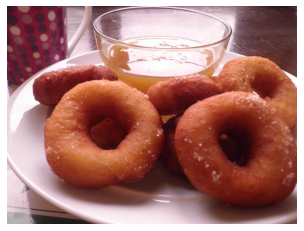

pred: close up of plate of doughnuts on table
true: a close up of a plate of doughnuts on a table
the donuts are served on a platter with a dipping sauce .
fresh donuts on a plate with dipping sauce and a drink .
a plate full of plain doughnuts and a glaze dip .
a few doughnuts are placed around a yellow liquid on a plate .


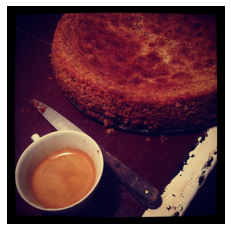

pred: close up of two pieces of cake on plate
true: a cake sitting on top of a wooden table next to a cup of coffee .
cup of coffee next to knife and baked desert item .
a close up of a cake , bowl of sauce and a knife .
cup of hot chocolate next to an unfrosted layer of cake .
a round cake , knifes and a cup of coffee .


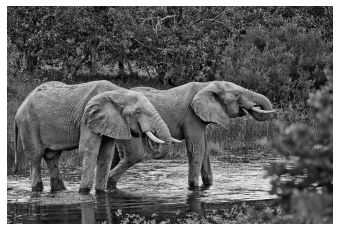

pred: two elephants stand in pond with their trunks in the water .
true: two elephants stand in a pond with their trunks in their mouths drinking .
two elephants standing side by side , drink water from the river
a pair of elephants standing in swampy water putting food in their mouths .
two elephants are walking through a body of water .
two elephants in a creek with their trunks in their mouth


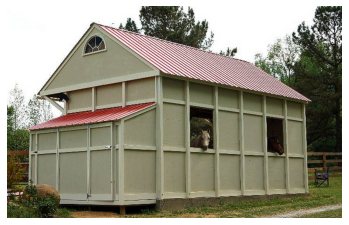

pred: horses are looking out of the windows of barn .
true: horses are looking out of the windows of a bard .
this is a barn with a horse peeking his head out
horses take a look outside of a window in their shed
horses peek through the windows of a small utilitarian horse barn .
horses look out the windows of a horse barn .


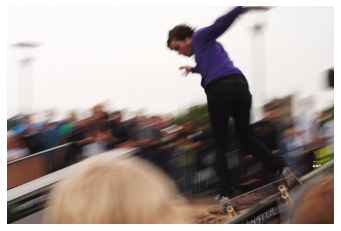

pred: person riding skate board at skate park
true: a person riding a skate baord while a group of people watch
a skateboarder doing tricks during a tournament
a blurry photo of a skateboarder doing tricks while people watch .
a young man riding a skateboard over a crowd of people .
very blurry image of a man skate boarding


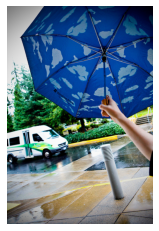

pred: person holding an umbrella with truck in the background
true: a person holding an umbrella with a truck in the background
a person holding a blue umbrella in the rain .
a personal holding a blue umbrella on a rainy day ,
somebody is holding a blue umbrella in the rain .
a hand is holding up an umbrella on the street .


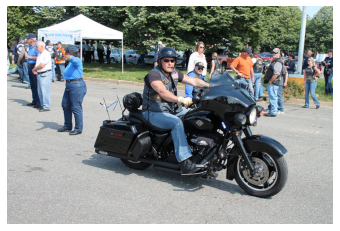

pred: man sitting on motor cycle in city .
true: there is a man sitting on a all black motor cycle
a man riding a motorcycle next to another man .
a man on his motorcycle in the street amongst a crowd
a man on a bike at sum sort of festival .
adult male biker on a motorcycle at an event .


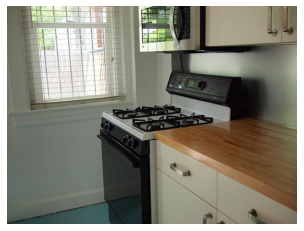

pred: black stove top oven in kitchen .
true: there is a black stove and wood cabinets in this kitchen
a gas range with a microwave oven mounted overhead .
a oven with old style burners on it .
a gas stove is pictured next to a window with blind in it .
a stove counter top microwave and cabinets by a window


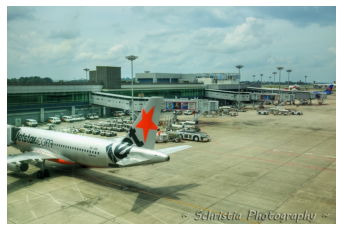

pred: photo of several planes at an airport .
true: a photo of several terminals and airplanes at an airport .
airplane being loaded on the tarmac at the airport .
an outside view of an airport terminal with planes
an airport tarmac with a plane and many vehicles
a large passenger jet parked on top of an airport tarmac .


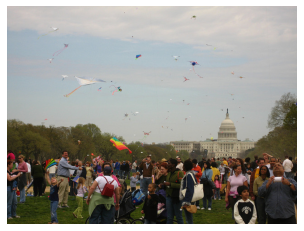

pred: crowd of people flying kites in park with building in the background
true: a crowd of people flying kites in a park with the capitol building in the background
lots of people flying different colored kites at a park .
this outside the capitol building where people are flying kites
a crowd in front of the capitol building is flying kites .
people gathered in a park flying kites with the capitol building in the background .


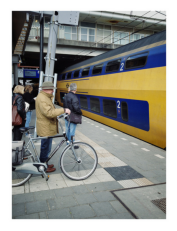

pred: person standing with bike by train .
true: a person standing with a bike by a train .
a man riding a bike next to a yellow and blue train .
people wait to board the yellow train with blue windows .
a man with his bicycle waiting for the subway
an older man waits at a train station for a passenger train .


In [29]:
for i, (vembed, captions, path) in enumerate(val_loader):
    with torch.no_grad():
        vembed = vembed.cuda()
        num_tokens = vembed.shape[0]
        src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
        tgt_tokens = greedy_decode(
            bertload, vembed, src_mask, max_len=num_tokens + 5, start_symbol=1).flatten()
        img, img_bgr, _, = load_image(path[0])
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        predtokens = [vocab.idx2word[idx] for idx in tgt_tokens.cpu().numpy() if idx > 4]
        gts = path_caption_dict[path[0]]
        truetokens = [' '.join(nltk.tokenize.word_tokenize(str(s).lower())) for s in gts]
        print('pred: ' + " ".join(predtokens))
        print('true: ' + "\n".join(truetokens))
        if i == 10:
            break

###Caclulate BLEU Score

In [30]:
references = [] 
hypotheses = []
for i, (vembed, captions, path) in enumerate(tqdm(val_loader)):
    with torch.no_grad():
        vembed = vembed.cuda()
        num_tokens = vembed.shape[0]
        src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
        tgt_tokens = greedy_decode(
            bertload, vembed, src_mask, max_len=num_tokens + 5, start_symbol=1).flatten()
        predtokens = [vocab.idx2word[idx] for idx in tgt_tokens.cpu().numpy() if idx > 4]
        gts = path_caption_dict[path[0]]
        # truetokens = [' '.join(nltk.tokenize.word_tokenize(str(s).lower())) for s in gts]
        truetokens = [nltk.tokenize.word_tokenize(str(s).lower()) for s in gts]
        references.append(truetokens)
        # hypotheses.append(' '.join(predtokens))
        hypotheses.append(predtokens)
        # if i == 100:
        #     break
bleu = corpus_bleu(references, hypotheses, smoothing_function=SmoothingFunction().method1)
bleu_1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)
bleu_2 = corpus_bleu(references, hypotheses, weights=(0, 1, 0, 0), smoothing_function=SmoothingFunction().method1)
bleu_3 = corpus_bleu(references, hypotheses, weights=(0, 0, 1, 0), smoothing_function=SmoothingFunction().method1)
bleu_4 = corpus_bleu(references, hypotheses, weights=(0, 0, 0, 1), smoothing_function=SmoothingFunction().method1)
print("BLEU: "+str(bleu))
print("BLEU-1: "+str(bleu_1))
print("BLEU-2: "+str(bleu_2))
print("BLEU-3: "+str(bleu_3))
print("BLEU-4: "+str(bleu_4))

100%|██████████| 1000/1000 [01:53<00:00,  8.80it/s]


BLEU: 0.4014984972776296
BLEU-1: 0.7722005444201101
BLEU-2: 0.49695535522196616
BLEU-3: 0.31941964069052264
BLEU-4: 0.21199548000240007


YAY, BLEU Score is great!😆